In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

from models.ensemble import EnsembleModel, ModelWithHead, ReadoutAdapter

try:
    IterativeRefinementNet
except NameError:
    class IterativeRefinementNet(nn.Module):
        def __init__(self, input_size, hidden_sizes, num_iterations, output_size, activation_str):
            super().__init__()
            act = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation_str]
            layers = []
            last = input_size
            for h in hidden_sizes:
                layers += [nn.Linear(last, h), act]
                last = h
            layers.append(nn.Linear(last, output_size))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x.view(x.size(0), -1))

try:
    StandardFeedForwardNet
except NameError:
    class StandardFeedForwardNet(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size, activation_str):
            super().__init__()
            act = {"relu": nn.ReLU(), "tanh": nn.Tanh(), "sigmoid": nn.Sigmoid()}[activation_str]
            layers = []
            last = input_size
            for h in hidden_sizes:
                layers += [nn.Linear(last, h), act]
                last = h
            layers.append(nn.Linear(last, output_size))
            self.net = nn.Sequential(*layers)
        def forward(self, x):
            return self.net(x.view(x.size(0), -1))


In [16]:
def get_monk1_data(batch_size, data_root='./data'):
    monk_dir = os.path.join(data_root, 'monk')
    os.makedirs(monk_dir, exist_ok=True)
    
    train_file = os.path.join(monk_dir, 'monks-1.train')
    test_file = os.path.join(monk_dir, 'monks-1.test')
    
    # Download if files don't exist
    if not os.path.exists(train_file):
        print("Downloading MONK-1 train data...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/monks-problems/monks-1.train"
        r = requests.get(url)
        with open(train_file, 'w') as f:
            f.write(r.text)
            
    if not os.path.exists(test_file):
        print("Downloading MONK-1 test data...")
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/monks-problems/monks-1.test"
        r = requests.get(url)
        with open(test_file, 'w') as f:
            f.write(r.text)

    # One-hot encoding definitions for 6 attributes (Total: 17 features)
    attr_dims = [3, 3, 2, 3, 4, 2]
    
    def parse_monk_file(file_path):
        features = []
        labels = []
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                
                label = int(parts[0])
                attrs = [int(a) for a in parts[1:-1]] # last part is ID
                
                # One-hot encode features
                one_hot_features = []
                for i, attr_val in enumerate(attrs):
                    one_hot = torch.zeros(attr_dims[i])
                    one_hot[attr_val - 1] = 1.0 # Values are 1-based
                    one_hot_features.append(one_hot)
                
                features.append(torch.cat(one_hot_features))
                labels.append(label)
                
        return torch.stack(features), torch.tensor(labels, dtype=torch.long)

    print("Parsing MONK-1 data...")
    train_x, train_y = parse_monk_file(train_file)
    test_x, test_y = parse_monk_file(test_file)
    
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    input_size = 17
    output_size = 2
    
    return train_loader, test_loader, input_size, output_size

def get_ml_cup_data(batch_size, data_root='.'):
    # data will be in ./MLC25/
    ml_cup_dir = os.path.join(data_root, 'MLC25')
    os.makedirs(ml_cup_dir, exist_ok=True)
    
    train_file = os.path.join(ml_cup_dir, 'ML-CUP25-TR.csv')
    test_file = os.path.join(ml_cup_dir, 'ML-CUP25-TS.csv')
    
    # --- Check if files exist ---
    if not os.path.exists(train_file) or not os.path.exists(test_file):
        print("---" * 20)
        print(f"ERROR: ML-CUP dataset files not found.")
        print(f"This script cannot download the ML-CUP dataset automatically.")
        print(f"Please manually place your dataset files at these locations:")
        print(f"Training data: {os.path.abspath(train_file)}")
        print(f"Test data:     {os.path.abspath(test_file)}")
        print("---" * 20)
        sys.exit(1) # Stop the script

    # --- Parser for ML-CUP data ---
    # This parser assumes the standard ML-CUP format:
    # - Lines starting with '#' are comments
    # - Data is comma-separated
    # - Column 0: ID (ignored)
    # - Columns 1-10: 10 input features
    # - Columns 11-12: 2 output targets (regression)
    def parse_ml_cup_file(file_path):
        features = []
        labels = []
        with open(file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                
                parts = line.split(',')
                if len(parts) < 13:
                    print(f"Warning: Skipping malformed line: {line}")
                    continue
                
                try:
                    # Features are columns 1 through 10 (10 features)
                    feature_values = [float(p) for p in parts[1:11]]
                    # Labels are columns 11 and 12 (2 targets)
                    label_values = [float(p) for p in parts[11:13]]
                    
                    features.append(torch.tensor(feature_values, dtype=torch.float32))
                    labels.append(torch.tensor(label_values, dtype=torch.float32))
                except ValueError as e:
                    print(f"Warning: Skipping line due to parsing error ({e}): {line}")

        return torch.stack(features), torch.stack(labels)

    print("Parsing ML-CUP data...")
    train_x, train_y = parse_ml_cup_file(train_file)
    test_x, test_y = parse_ml_cup_file(test_file)
    
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # Based on the parser above
    input_size = 10
    output_size = 2
    
    print("---" * 10)
    print("WARNING: The 'step_out' model uses a final-state activation (e.g., ReLU).")
    print("This is likely unsuitable for the ML-CUP regression task (which can have")
    print("negative targets). The 'standard' model is recommended.")
    print("---" * 10)
    
    return train_loader, test_loader, input_size, output_size

In [10]:
import json

## configuration presets
config_presets = {
    "monk1_standard": {
        "model": "standard",
        "dataset": "monk1",
        "activation": "tanh",
        "hidden_sizes": [3],
        "epochs": 1000,
        "batch_size": 64,
        "lr": 0.001
    },

    "mlcup_standard": {
        "model": "standard",
        "dataset": "mlc25",
        "activation": "tanh",
        "hidden_sizes": [50, 20],
        "epochs": 150,
        "batch_size": 64,
        "lr": 0.001
    },

    "mnist_standard": {
        "model": "standard",
        "dataset": "mnist",
        "activation": "sigmoid",
        "hidden_sizes": [256, 128, 64],
        "epochs": 10,
        "batch_size": 64,
        "lr": 0.001
    },

    "mnist_stepout": {
        "model": "step_out",
        "dataset": "mnist",
        "activation": "sigmoid",
        "hidden_sizes": [256, 128, 64],
        "epochs": 10,
        "batch_size": 64,
        "lr": 0.001
    },

    "mnist_ensemble": {
        "model": "ensemble",
        "shared": {
            "dataset": "mnist",
            "epochs": 10,
            "batch_size": 64
        },
        "weights": [1.0, 1.0],  # [standard, step_out]
        "members": [
            {
                "name": "standard",
                "activation": "sigmoid",
                "hidden_sizes": [256, 128, 64],
                "lr": 0.001
            },
            {
                "name": "step_out",
                "activation": "sigmoid",
                "hidden_sizes": [256, 128, 64],
                "lr": 0.001
            }
        ]
    },

    "mlc25_ensemble": {
        "model": "ensemble",
        "shared": {
            "dataset": "mlc25",
            "epochs": 150,
            "batch_size": 64
        },
        "weights": [1.0, 1.0],
        "members": [
            {
                "name": "standard",
                "activation": "tanh",
                "hidden_sizes": [50, 20],
                "lr": 0.001
            },
            {
                "name": "step_out",
                "activation": "tanh",
                "hidden_sizes": [50, 20],
                "lr": 0.001
            }
        ]
    }
}

def select_preset(key: str):
    """Flattens ensemble presets into a compact cfg the rest
    of the notebook can consume easily."""
    base = config_presets[key]
    if base.get("model") != "ensemble":
        return base  # single-model cfg as-is

    flat = {
        "model": "ensemble",
        # shared training knobs:
        "dataset": base["shared"]["dataset"],
        "epochs": base["shared"]["epochs"],
        "batch_size": base["shared"]["batch_size"],
        # ensemble-specific:
        "weights": base.get("weights", [1.0] * len(base["members"])),
        "members": base["members"]
    }
    return flat

cfg = select_preset("mlc25_ensemble") 

if cfg["model"] == "ensemble":
    # Use first member as representative for globals
    first_member = cfg["members"][0]
    HIDDEN_SIZES = first_member["hidden_sizes"]
    ACTIVATION   = first_member["activation"]
    LEARNING_RATE = first_member.get("lr", 0.001)
else:
    HIDDEN_SIZES = cfg["hidden_sizes"]
    ACTIVATION   = cfg["activation"]
    LEARNING_RATE = cfg.get("lr", 0.001)

BATCH_SIZE = cfg["batch_size"]
NUM_EPOCHS = cfg["epochs"]
model = cfg["model"]

data_root = "./data"
is_regression_task = False

print("Config:", json.dumps(cfg, indent=2))

Config: {
  "model": "ensemble",
  "dataset": "mlc25",
  "epochs": 150,
  "batch_size": 64,
  "weights": [
    1.0,
    1.0
  ],
  "members": [
    {
      "name": "standard",
      "activation": "tanh",
      "hidden_sizes": [
        50,
        20
      ],
      "lr": 0.001
    },
    {
      "name": "step_out",
      "activation": "tanh",
      "hidden_sizes": [
        50,
        20
      ],
      "lr": 0.001
    }
  ]
}


In [17]:
# Dataset loading + task type

train_loader = None
test_loader = None
INPUT_SIZE = None
OUTPUT_SIZE = None
metric_name = "Test Accuracy"

print(f"Loading dataset: {cfg['dataset'].upper()}")

if cfg["dataset"] == "monk1":
    train_loader, test_loader, INPUT_SIZE, OUTPUT_SIZE = get_monk1_data(BATCH_SIZE, data_root)
    metric_name = "Test monk"

elif cfg["dataset"] == "mlc25":
    train_loader, test_loader, INPUT_SIZE, OUTPUT_SIZE = get_ml_cup_data(BATCH_SIZE)
    is_regression_task = True
    metric_name = "Test MSE"

else:
    if cfg["dataset"] == "mnist":
        normalize_mean, normalize_std = (0.1307,), (0.3081,)
        dataset_class = torchvision.datasets.MNIST
    elif cfg["dataset"] == "fmnist":
        normalize_mean, normalize_std = (0.2860,), (0.3530,)
        dataset_class = torchvision.datasets.FashionMNIST
    elif cfg["dataset"] == "kmnist":
        normalize_mean, normalize_std = (0.1918,), (0.3483,)
        dataset_class = torchvision.datasets.KMNIST
    else:
        raise ValueError(f"Unknown dataset: {cfg['dataset']}")

    INPUT_SIZE = 28 * 28
    OUTPUT_SIZE = 10

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(normalize_mean, normalize_std)
    ])

    train_dataset = dataset_class(root=data_root, train=True, transform=transform, download=True)
    test_dataset  = dataset_class(root=data_root, train=False, transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Detected Input Size: {INPUT_SIZE}, Output Size: {OUTPUT_SIZE}")


Loading dataset: MLC25
Parsing ML-CUP data...


NameError: name 'TensorDataset' is not defined

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps'); print("Using device: Apple MPS")
elif torch.cuda.is_available():
    device = torch.device('cuda'); print("Using device: NVIDIA CUDA")
else:
    device = torch.device('cpu'); print("Using device: CPU")

Using device: Apple MPS


In [5]:
def build_member_model(member_cfg, input_size, output_size, device):
    name = member_cfg["name"].lower()
    act  = member_cfg["activation"]
    hids = member_cfg["hidden_sizes"]

    if name == "standard":
        base = StandardFeedForwardNet(
            input_size=input_size,
            hidden_sizes=hids,
            output_size=output_size,
            activation_str=act
        ).to(device)
    elif name == "step_out":
        base = IterativeRefinementNet(
            input_size=input_size,
            hidden_sizes=hids,
            num_iterations=len(hids),
            output_size=output_size,
            activation_str=act
        ).to(device)
    else:
        raise ValueError(f"Unknown ensemble member name: {name}")
    return base

# --- Build models from cfg (single or ensemble) ---
members_wrapped = []
optimizers = []
ensemble = None

# --- Task mode from your dataset branch ---
task_mode = "regression" if is_regression_task else "classification"

if cfg.get("model") == "ensemble":
    # Expect: cfg["members"] (list of dicts) and cfg["weights"]
    bases = [build_member_model(m, INPUT_SIZE, OUTPUT_SIZE, device) for m in cfg["members"]]
    # add readout heads (classification needs logits)
    adapters = [ReadoutAdapter(OUTPUT_SIZE, OUTPUT_SIZE, task_mode) for _ in bases]
    members_wrapped = [ModelWithHead(b, a).to(device) for b, a in zip(bases, adapters)]
    # per-member lrs (from preset); fallback to global LEARNING_RATE if missing
    for wrapped, m in zip(members_wrapped, cfg["members"]):
        lr_m = m.get("lr", LEARNING_RATE)
        optimizers.append(optim.Adam(wrapped.parameters(), lr=lr_m))
    # ensemble with weights
    ensemble = EnsembleModel(members_wrapped, weights=cfg.get("weights", None)).to(device)

    print(f"Ensemble with {len(members_wrapped)} members. Weights:", 
          (ensemble.weights / ensemble.weights.sum()).cpu().tolist())
    for i, (mw, opt) in enumerate(zip(members_wrapped, optimizers), 1):
        params = sum(p.numel() for p in mw.parameters())
        print(f" Member {i}: params={params}, lr={opt.param_groups[0]['lr']}")

else:
    # Single-model path (keeps your previous behavior)
    if cfg["model"] == "standard":
        base = StandardFeedForwardNet(INPUT_SIZE, cfg["hidden_sizes"], OUTPUT_SIZE, cfg["activation"]).to(device)
    elif cfg["model"] == "step_out":
        base = IterativeRefinementNet(INPUT_SIZE, cfg["hidden_sizes"], len(cfg["hidden_sizes"]), OUTPUT_SIZE, cfg["activation"]).to(device)
    else:
        raise ValueError(f"Unknown model: {cfg['model']}")
    # classification: ensure logits; regression: identity
    wrapped = ModelWithHead(base, ReadoutAdapter(OUTPUT_SIZE, OUTPUT_SIZE, task_mode)).to(device)
    members_wrapped = [wrapped]
    optimizers = [optim.Adam(wrapped.parameters(), lr=LEARNING_RATE)]
    ensemble = None  # not used
    print("Single model params:", sum(p.numel() for p in wrapped.parameters()))


Ensemble with 2 members. Weights: [0.5, 0.5]
 Member 1: params=242872, lr=0.001
 Member 2: params=242872, lr=0.001


In [ ]:
# Cell B: build models (single or ensemble), train, and evaluate

# --- Build models from cfg (single or ensemble) ---
members_wrapped = []
optimizers = []
ensemble = None

if cfg.get("model") == "ensemble":
    bases = [build_member_model(m, INPUT_SIZE, OUTPUT_SIZE, device) for m in cfg["members"]]
    # add readout heads (classification needs logits)
    adapters = [ReadoutAdapter(OUTPUT_SIZE, OUTPUT_SIZE, task_mode) for _ in bases]
    members_wrapped = [ModelWithHead(b, a).to(device) for b, a in zip(bases, adapters)]
    for wrapped, m in zip(members_wrapped, cfg["members"]):
        lr_m = m.get("lr", LEARNING_RATE)
        optimizers.append(optim.Adam(wrapped.parameters(), lr=lr_m))
    # ensemble with weights
    ensemble = EnsembleModel(members_wrapped, weights=cfg.get("weights", None)).to(device)

    print(f"Ensemble with {len(members_wrapped)} members. Weights:", 
          (ensemble.weights / ensemble.weights.sum()).cpu().tolist())
    for i, (mw, opt) in enumerate(zip(members_wrapped, optimizers), 1):
        params = sum(p.numel() for p in mw.parameters())
        print(f" Member {i}: params={params}, lr={opt.param_groups[0]['lr']}")

else:
    # Single-model path (keeps your previous behavior)
    if cfg["model"] == "standard":
        base = StandardFeedForwardNet(INPUT_SIZE, cfg["hidden_sizes"], OUTPUT_SIZE, cfg["activation"]).to(device)
    elif cfg["model"] == "step_out":
        base = IterativeRefinementNet(INPUT_SIZE, cfg["hidden_sizes"], len(cfg["hidden_sizes"]), OUTPUT_SIZE, cfg["activation"]).to(device)
    else:
        raise ValueError(f"Unknown model: {cfg['model']}")
    # classification: ensure logits; regression: identity
    wrapped = ModelWithHead(base, ReadoutAdapter(OUTPUT_SIZE, OUTPUT_SIZE, task_mode)).to(device)
    members_wrapped = [wrapped]
    optimizers = [optim.Adam(wrapped.parameters(), lr=LEARNING_RATE)]
    ensemble = None  # not used
    print("Single model params:", sum(p.numel() for p in wrapped.parameters()))

# --- Tracking ---
epoch_train_losses = []
epoch_test_individual = []   # list of per-epoch per-member metrics
epoch_test_ensemble = []     # list of scalar ensemble metrics (if any)

Ensemble with 2 members. Weights: [0.5, 0.5]
 Member 1: params=242872, lr=0.001
 Member 2: params=242872, lr=0.001


In [7]:
# Criterion, optimizers, trackers (single or ensemble)

criterion = nn.MSELoss() if is_regression_task else nn.CrossEntropyLoss()

# Build training targets depending on cfg["model"]
# - Single: `model` already exists, we wrap it into lists for uniform handling
# - Ensemble: expect `members_wrapped`, `optimizers` already created (from Cell A/B)
if cfg.get("model") == "ensemble":
    train_members = members_wrapped                 # list[nn.Module]
    member_opts   = optimizers                      # list[torch.optim.Optimizer]
    ensemble_model = ensemble                       # EnsembleModel (or None)
else:
    # single-model fallback (use your existing 'model' and 'optimizer')
    train_members = [model]
    member_opts   = [optim.Adam(model.parameters(), lr=LEARNING_RATE)]
    ensemble_model = None

epoch_train_losses = []
epoch_test_individual = []   # per-member metric each epoch
epoch_test_ensemble = []     # ensemble metric each epoch (if any)

print(f"Training for {NUM_EPOCHS} epochs on "
      f"{'regression' if is_regression_task else 'classification'} task "
      f"with {'ensemble' if cfg.get('model')=='ensemble' else 'single model'}...")

Training for 10 epochs on classification task with ensemble...


In [8]:
# Training loop (single or ensemble) + evaluation

def evaluate_all(members, ensemble_model, loader, device, is_regression, criterion):
    for m in members:
        m.eval()
    if ensemble_model is not None:
        ensemble_model.eval()

    with torch.no_grad():
        if is_regression:
            mses = [0.0 for _ in members]
            mse_ens = 0.0
            n = 0
            for data, labels in loader:
                data, labels = data.to(device), labels.to(device)
                preds = [m(data) for m in members]
                for i, p in enumerate(preds):
                    mses[i] += criterion(p, labels).item()
                if ensemble_model is not None:
                    mse_ens += criterion(ensemble_model(data), labels).item()
                n += 1
            mses = [m / n for m in mses]
            mse_ens = (mse_ens / n) if ensemble_model is not None else None
            return {"individual": mses, "ensemble": mse_ens}
        else:
            corrects = [0 for _ in members]
            correct_ens = 0
            total = 0
            for data, labels in loader:
                data, labels = data.to(device), labels.to(device)
                logits_list = [m(data) for m in members]
                for i, logits in enumerate(logits_list):
                    _, pred = torch.max(logits, 1)
                    corrects[i] += (pred == labels).sum().item()
                if ensemble_model is not None:
                    logits_ens = ensemble_model(data)
                    _, pred_ens = torch.max(logits_ens, 1)
                    correct_ens += (pred_ens == labels).sum().item()
                total += labels.size(0)
            accs = [100.0 * c / total for c in corrects]
            acc_ens = (100.0 * correct_ens / total) if ensemble_model is not None else None
            return {"individual": accs, "ensemble": acc_ens}

for epoch in range(NUM_EPOCHS):
    for m in train_members:
        m.train()

    running_loss = 0.0

    for i, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)

        # forward per member
        outs = [m(data) for m in train_members]
        # per-member losses (same criterion for both tasks)
        losses = [criterion(o, labels) for o in outs]
        total_loss = sum(losses)  # equal weights; tweak if desired

        # optimize
        for opt in member_opts:
            opt.zero_grad()
        total_loss.backward()
        for opt in member_opts:
            opt.step()

        running_loss += total_loss.item()

        # logging
        log_frequency = max(1, len(train_loader) // 4)
        if (i + 1) % log_frequency == 0 or (i + 1) == len(train_loader):
            loss_str = "  ".join([f"L{i+1}:{l.item():.4f}" for i, l in enumerate(losses)])
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], {loss_str}  Sum:{total_loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] complete. Average Training Loss (sum of members): {avg_train_loss:.4f}")

    # --- Evaluation ---
    metrics = evaluate_all(train_members, ensemble_model, test_loader, device, is_regression_task, criterion)
    epoch_test_individual.append(metrics["individual"])
    if metrics["ensemble"] is not None:
        epoch_test_ensemble.append(metrics["ensemble"])

    if is_regression_task:
        if metrics["ensemble"] is None:
            print("Average Test MSEs -> " + "  ".join([f"M{i+1}:{m:.4f}" for i, m in enumerate(metrics['individual'])]))
        else:
            print("Average Test MSEs -> " + "  ".join([f"M{i+1}:{m:.4f}" for i, m in enumerate(metrics['individual'])]) +
                  f", Ensemble:{metrics['ensemble']:.4f} (lower is better)")
    else:
        if metrics["ensemble"] is None:
            print("Accuracies -> " + "  ".join([f"M{i+1}:{m:.2f}%" for i, m in enumerate(metrics['individual'])]))
        else:
            print("Accuracies -> " + "  ".join([f"M{i+1}:{m:.2f}%" for i, m in enumerate(metrics['individual'])]) +
                  f", Ensemble:{metrics['ensemble']:.2f}%")

print("Finished Training!")


Epoch [1/10], Step [234/938], L1:0.9020  L2:1.0108  Sum:1.9128
Epoch [1/10], Step [468/938], L1:0.3023  L2:0.3975  Sum:0.6998
Epoch [1/10], Step [702/938], L1:0.2067  L2:0.2160  Sum:0.4227
Epoch [1/10], Step [936/938], L1:0.3268  L2:0.3666  Sum:0.6935
Epoch [1/10], Step [938/938], L1:0.2885  L2:0.4597  Sum:0.7483
Epoch [1/10] complete. Average Training Loss (sum of members): 1.3436
Accuracies -> M1:94.59%  M2:94.25%, Ensemble:95.04%
Epoch [2/10], Step [234/938], L1:0.1769  L2:0.2845  Sum:0.4615
Epoch [2/10], Step [468/938], L1:0.2910  L2:0.2060  Sum:0.4970
Epoch [2/10], Step [702/938], L1:0.0951  L2:0.2121  Sum:0.3072
Epoch [2/10], Step [936/938], L1:0.2655  L2:0.3007  Sum:0.5662
Epoch [2/10], Step [938/938], L1:0.2258  L2:0.5763  Sum:0.8021
Epoch [2/10] complete. Average Training Loss (sum of members): 0.3607
Accuracies -> M1:96.24%  M2:95.69%, Ensemble:96.44%
Epoch [3/10], Step [234/938], L1:0.1103  L2:0.0952  Sum:0.2055
Epoch [3/10], Step [468/938], L1:0.0484  L2:0.0424  Sum:0.0908


Generating plot...


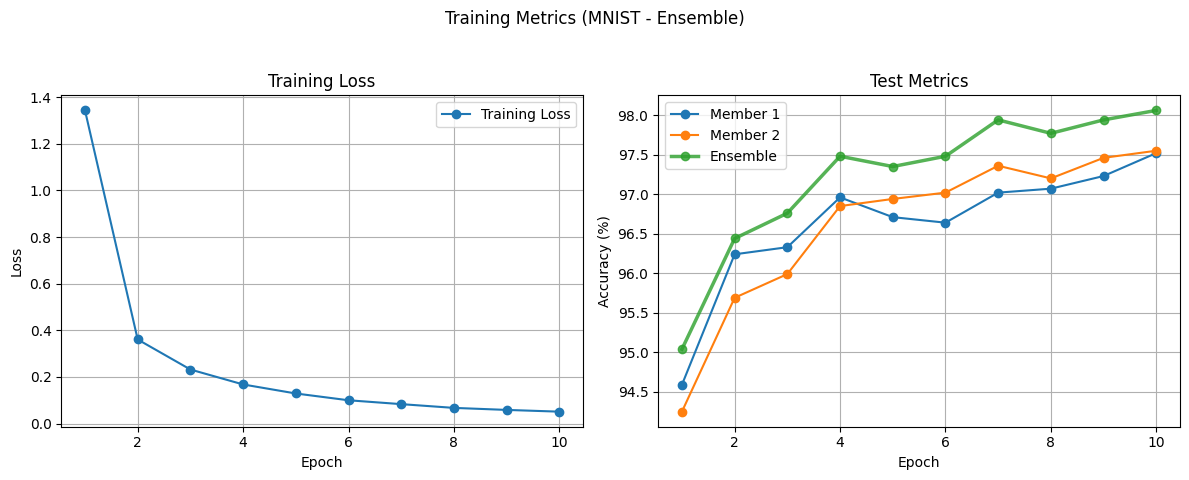

In [9]:
print("Generating plot...")
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# ---- Left subplot: Training loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, epoch_train_losses, 'o-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---- Right subplot: Test metrics ----
plt.subplot(1, 2, 2)

if cfg.get("model") == "ensemble":
    # Each element in epoch_test_individual = list of member metrics
    n_members = len(epoch_test_individual[0])
    for m_idx in range(n_members):
        vals = [ep[m_idx] for ep in epoch_test_individual]
        label = f"Member {m_idx+1}"
        plt.plot(epochs_range, vals, 'o-', label=label)

    # Ensemble curve if available
    if len(epoch_test_ensemble) > 0:
        plt.plot(epochs_range, epoch_test_ensemble, 'o-', linewidth=2.5, label="Ensemble", alpha=0.8)
        ylabel = "MSE" if is_regression_task else "Accuracy (%)"
    else:
        ylabel = "Metric"

else:
    # Single-model fallback
    plt.plot(epochs_range, epoch_test_individual, 'o-', label='Test Metric')
    ylabel = metric_name

plt.title('Test Metrics')
plt.xlabel('Epoch')
plt.ylabel(ylabel)
plt.legend()
plt.grid(True)

plt.suptitle(f"Training Metrics ({cfg['dataset'].upper()} - {cfg['model'].title()})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()